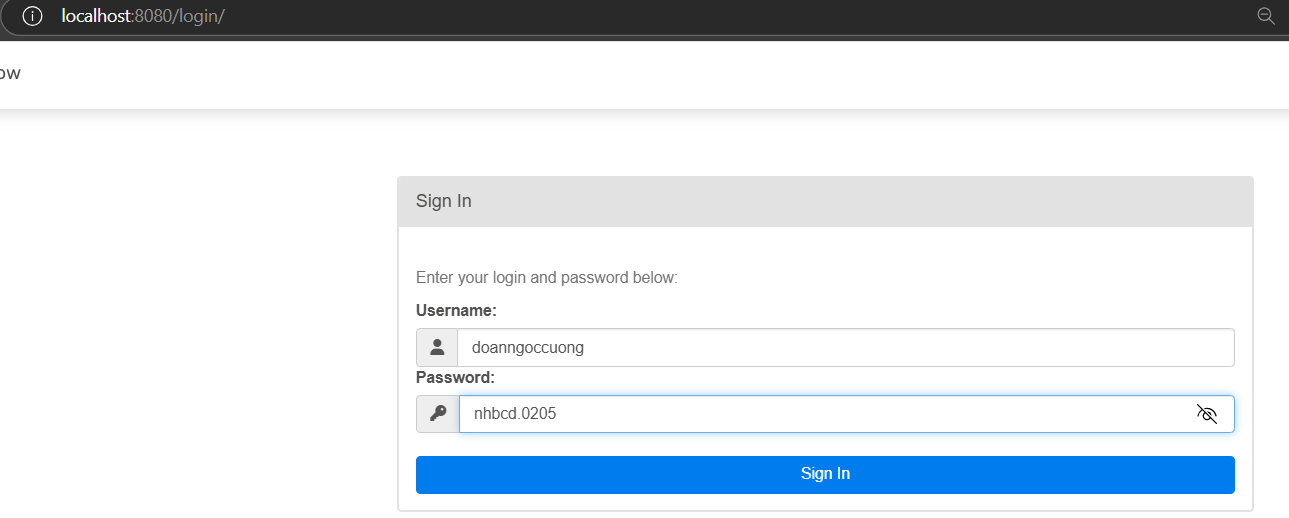

Dưới đây là bảng liệt kê các dịch vụ trong tệp `docker-compose.yml` của bạn, cùng với các cổng (ports) mà mỗi dịch vụ sử dụng:

| **Dịch Vụ**            | **Mô Tả**                                                  | **Cổng Nội Bộ**  | **Cổng Bên Ngoài** |
|------------------------|----------------------------------------------------------|-----------------|-------------------|
| **Zookeeper**          | Quản lý cấu hình và đồng bộ trạng thái cho Kafka Broker. | `2181`          | `2181`            |
| **Kafka Broker**       | Xử lý các yêu cầu sản xuất và tiêu thụ dữ liệu Kafka.    | `29092`, `9092` | `9092`            |
| **Schema Registry**    | Quản lý và lưu trữ các schema dữ liệu Kafka.             | `8081`          | `8081`            |
| **Control Center**     | Giao diện quản lý và giám sát Kafka Cluster.             | `9021`          | `9021`            |
| **Airflow Webserver**  | Giao diện người dùng cho quản lý workflow của Airflow.   | `8080`          | `8080`            |
| **Spark Master**       | Quản lý và điều phối các worker Spark.                   | `8080`, `7077`  | `9090`, `7077`    |
| **Spark Worker**       | Xử lý tác vụ phân tán theo điều phối của Spark Master.  | `N/A`           | `N/A`             |
| **Postgres**           | Cơ sở dữ liệu PostgreSQL cho metadata của Airflow.       | `5432`          | `5432`            |
| **Cassandra DB**       | Cơ sở dữ liệu NoSQL Cassandra.                           | `9042`          | `9042`            |

---

### Ghi chú:
- **Cổng nội bộ:** Là cổng mà dịch vụ sử dụng bên trong container.
- **Cổng bên ngoài:** Là cổng ánh xạ ra từ container để các dịch vụ bên ngoài (hoặc trên host) có thể truy cập.

---

### Ví dụ minh họa cách hoạt động:
1. **Kafka Broker**:
   - Cổng nội bộ `29092` được các dịch vụ khác (như Schema Registry hoặc Control Center) trong cùng mạng Docker sử dụng.
   - Cổng bên ngoài `9092` cho phép các ứng dụng trên host kết nối với Kafka Broker.

2. **Airflow Webserver**:
   - Cổng `8080` cho phép bạn truy cập giao diện người dùng qua trình duyệt tại `http://localhost:8080`.

---

Nếu bạn cần thêm thông tin hoặc mở rộng bảng này, hãy cho biết!

## password airflow


Theo cấu hình trong `docker-compose.yml` mà bạn cung cấp, mật khẩu đăng nhập của **Airflow Webserver** (truy cập qua cổng `8080`) được tạo tự động trong phần script `entrypoint.sh`. Cụ thể:

### Mật khẩu mặc định:
- **Tài khoản:** `admin`
- **Mật khẩu:** `admin`

### Phần script:
```bash
airflow users create \
  --username admin \
  --firstname admin \
  --lastname admin \
  --role Admin \
  --email admin@example.com \
  --password admin
```

---

### Kiểm tra hoặc thay đổi mật khẩu:
Nếu muốn thay đổi mật khẩu, bạn có thể:
1. Sửa trực tiếp trong tệp `entrypoint.sh`:
   ```bash
   airflow users create \
     --username admin \
     --firstname admin \
     --lastname admin \
     --role Admin \
     --email admin@example.com \
     --password new_password_here
   ```
2. Hoặc truy cập vào container và sử dụng lệnh sau để thay đổi:
   ```bash
   docker exec -it bigdata-project-webserver-1 bash
   airflow users update \
     --username admin \
     --password new_password_here
   ```

---

### Truy cập Webserver:
Sau khi khởi động, bạn có thể truy cập **Airflow Webserver** tại [http://localhost:8080](http://localhost:8080) với thông tin đăng nhập mặc định. Nếu gặp lỗi đăng nhập, hãy kiểm tra log của container Webserver để xác nhận việc tạo tài khoản thành công.

1. Vào airflow web server: localhost:8080
- Đăng nhập với tài khoản admin và mật khẩu admin
- Run workflow, nó sẽ tự động click vào DAG `dags/kafka-stream` và chạy luồng để kéo dữ liệu từ API vào Kafka

2. vào Control Center: localhost:9021
- Check topic `users_created`
- Check data đã được đẩy lên Kafka chưa
```bash
docker exec -it broker kafka-console-consumer
 --bootstrap-server broker:29092 --topic users_created --from-beginning
```
- Check data đã vào Cassandra chưa, bằng cách xem topic trên Control Center: http://localhost:9021/clusters/_B-EUdw9RSKFvCU2fGgr_Q/management/topics/users_created/message-viewer

Chú ý cần đăng ký Schema cho topic `users_created` trước khi check data trên Control Center
```
curl -X POST -H "Content-Type: application/vnd.schemaregistry.v1+json" \
     --data '{
       "schema": "{\"type\":\"record\",\"name\":\"User\",\"fields\":[{\"name\":\"first_name\",\"type\":\"string\"},{\"name\":\"last_name\",\"type\":\"string\"},{\"name\":\"gender\",\"type\":\"string\"},{\"name\":\"address\",\"type\":\"string\"},{\"name\":\"post_code\",\"type\":\"string\"},{\"name\":\"email\",\"type\":\"string\"},{\"name\":\"username\",\"type\":\"string\"},{\"name\":\"dob\",\"type\":\"string\"},{\"name\":\"registered_date\",\"type\":\"string\"},{\"name\":\"phone\",\"type\":\"string\"},{\"name\":\"picture\",\"type\":\"string\"}]}"
     }' http://localhost:8081/subjects/users_created-value/versions

```


```
tại sao check bằng
bash
docker exec -it broker kafka-console-consumer
 --bootstrap-server broker:29092 --topic users_created --from-beginning


thấy dataset rồi 
mà sao trên http://localhost:9021/clusters/_B-EUdw9RSKFvCU2fGgr_Q/management/topics/users_created/message-viewer

lại báo: no message
```
#### fix 1 hồi thì là do cần phải **Đăng ký Schema cho topic `users_created`:**

```
curl -X POST -H "Content-Type: application/vnd.schemaregistry.v1+json" \
     --data '{
       "schema": "{\"type\":\"record\",\"name\":\"User\",\"fields\":[{\"name\":\"first_name\",\"type\":\"string\"},{\"name\":\"last_name\",\"type\":\"string\"},{\"name\":\"gender\",\"type\":\"string\"},{\"name\":\"address\",\"type\":\"string\"},{\"name\":\"post_code\",\"type\":\"string\"},{\"name\":\"email\",\"type\":\"string\"},{\"name\":\"username\",\"type\":\"string\"},{\"name\":\"dob\",\"type\":\"string\"},{\"name\":\"registered_date\",\"type\":\"string\"},{\"name\":\"phone\",\"type\":\"string\"},{\"name\":\"picture\",\"type\":\"string\"}]}"
     }' http://localhost:8081/subjects/users_created-value/versions

```